In [28]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from scipy import stats
from ast import literal_eval
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from torch.utils.data import DataLoader, TensorDataset

In [29]:
apps_data = pd.read_csv('filtered_apps.csv')
users_data = pd.read_csv('filtered_users.csv')
jobs_data = pd.read_csv('filtered_jobs.csv')

In [30]:
apps = apps_data.copy()
users = users_data.copy()
jobs = jobs_data.copy()

In [31]:
unique_JobID = apps['JobID'].unique()
unique_UserID = apps['UserID'].unique()
j = 0
user_old2new_id_dict = dict()
user_new2old_id_dict = dict()
for u in unique_UserID:
    user_old2new_id_dict[u] = j
    user_new2old_id_dict[j] = u
    j += 1
j = 0
job_old2new_id_dict = dict()
job_new2old_id_dict = dict()
for i in unique_JobID:
    job_old2new_id_dict[i] = j
    job_new2old_id_dict[j] = i
    j += 1

In [32]:
user_list = apps['UserID'].values
job_list = apps['JobID'].values
for j in range(len(apps)):
    user_list[j] = user_old2new_id_dict[user_list[j]]
    job_list[j] = job_old2new_id_dict[job_list[j]]
apps['UserID'] = user_list
apps['JobID'] = job_list

# generate train_df with 70% samples and test_df with 30% samples, and there should have no overlap between them.
train_index = np.random.random(len(apps)) <= 0.7
train_df = apps[train_index]
test_df = apps[~train_index]

In [33]:
train_df['Applied?'] = 1
test_df['Applied?'] = 1

from scipy.sparse import coo_matrix

# generate train_mat and test_mat
num_users = len(apps['UserID'].unique())
num_jobs = len(apps['JobID'].unique())

train_mat = coo_matrix((train_df['Applied?'].values, (train_df['UserID'].values, train_df['JobID'].values)), shape=(num_users, num_jobs)).astype(float).toarray()
test_mat = coo_matrix((test_df['Applied?'].values, (test_df['UserID'].values, test_df['JobID'].values)), shape=(num_users, num_jobs)).astype(float).toarray()

<ipython-input-33-f1ba62f7282d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['Applied?'] = 1
<ipython-input-33-f1ba62f7282d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['Applied?'] = 1


## MF Model

In [34]:
def MF_PreTrained_Embeddings(latent_factors, num_epochs):
  P = np.random.rand(num_users, latent_factors)
  Q = np.random.rand(latent_factors, num_jobs)

  a = 0.01
  b = 0.01
  train_loss = []
  test_loss = []
  nonzero_indices_train = np.nonzero(train_mat)
  nonzero_indices_test = np.nonzero(test_mat)

  for epoch in range(num_epochs):
      for i in range(num_users):
          for j in range(num_jobs):
              if train_mat[i, j] > 0:
                  diff = train_mat[i, j] - np.dot(P[i, :], Q[:, j])
                  P[i, :] += a * (diff * Q[:, j] - b * P[i, :])
                  Q[:, j] += a * (diff * P[i, :] - b * Q[:, j])

      predicted_matrix = np.dot(P, Q)

      rmse_train = np.sqrt(np.mean((predicted_matrix[nonzero_indices_train] - train_mat[nonzero_indices_train])**2))
      rmse_test = np.sqrt(np.mean((predicted_matrix[nonzero_indices_test] - test_mat[nonzero_indices_test])**2))

      train_loss.append(rmse_train)
      test_loss.append(rmse_test)

      print('Epoch', epoch + 1, 'of', num_epochs, end=': ')
      print('RMSE Train Loss: {:.4f}'.format(rmse_train), end=', ')
      print('RMSE Test Loss: {:.4f}'.format(rmse_test))

  return P, Q

In [35]:
latent_factors_for_MF = 5
num_epochs = 20
P1, Q1 = MF_PreTrained_Embeddings(latent_factors_for_MF, num_epochs)

Epoch 1 of 20: RMSE Train Loss: 0.4065, RMSE Test Loss: 0.4238
Epoch 2 of 20: RMSE Train Loss: 0.3336, RMSE Test Loss: 0.3606
Epoch 3 of 20: RMSE Train Loss: 0.2874, RMSE Test Loss: 0.3206
Epoch 4 of 20: RMSE Train Loss: 0.2549, RMSE Test Loss: 0.2923
Epoch 5 of 20: RMSE Train Loss: 0.2305, RMSE Test Loss: 0.2709
Epoch 6 of 20: RMSE Train Loss: 0.2114, RMSE Test Loss: 0.2540
Epoch 7 of 20: RMSE Train Loss: 0.1958, RMSE Test Loss: 0.2401
Epoch 8 of 20: RMSE Train Loss: 0.1829, RMSE Test Loss: 0.2286
Epoch 9 of 20: RMSE Train Loss: 0.1720, RMSE Test Loss: 0.2187
Epoch 10 of 20: RMSE Train Loss: 0.1625, RMSE Test Loss: 0.2101
Epoch 11 of 20: RMSE Train Loss: 0.1544, RMSE Test Loss: 0.2026
Epoch 12 of 20: RMSE Train Loss: 0.1471, RMSE Test Loss: 0.1960
Epoch 13 of 20: RMSE Train Loss: 0.1407, RMSE Test Loss: 0.1901
Epoch 14 of 20: RMSE Train Loss: 0.1350, RMSE Test Loss: 0.1848
Epoch 15 of 20: RMSE Train Loss: 0.1298, RMSE Test Loss: 0.1799
Epoch 16 of 20: RMSE Train Loss: 0.1251, RMSE Tes

In [66]:
P1

array([[ 0.61499939,  0.55747721,  0.6654069 ,  0.10410612,  0.25779505],
       [ 0.59688402,  0.15283283,  0.71423659,  0.21701342,  0.43705078],
       [ 0.48940721,  0.14444482,  0.69537756,  0.43325664,  0.36460837],
       ...,
       [ 0.72341687,  0.47670927,  0.32372443,  0.42536412,  0.15104292],
       [ 0.61772317,  0.58924582, -0.05381008,  0.75106155,  0.58602578],
       [ 0.26125577,  0.72023559,  0.68104296,  0.02240294,  0.59779581]])

In [36]:
train_df.head()

,UserID,WindowID,Split,ApplicationDate,JobID,Applied?
0,0,1,Train,2012-04-02 11:05:25.333,0,1
1,0,1,Train,2012-04-02 05:08:41.413,1,1
3,0,1,Train,2012-04-02 11:05:25.833,3,1
4,0,1,Train,2012-04-02 11:05:25.76,4,1
5,0,1,Train,2012-04-02 05:08:44.72,5,1


In [37]:
test_df.head()

,UserID,WindowID,Split,ApplicationDate,JobID,Applied?
2,0,1,Train,2012-04-02 11:05:24.333,2,1
8,0,1,Train,2012-04-02 05:08:40.687,8,1
10,0,1,Train,2012-04-02 11:05:23.78,10,1
12,0,1,Train,2012-04-02 11:05:25.01,12,1
15,0,1,Train,2012-04-02 11:05:25.1,15,1


In [38]:
from torch.utils.data import DataLoader, TensorDataset
import torch
train_user_ids = torch.LongTensor(train_df['UserID'].values)
train_job_ids = torch.LongTensor(train_df['JobID'].values)
train_job_features = torch.FloatTensor(train_df['Applied?'].values.astype(np.float32))

train_dataset = TensorDataset(train_user_ids, train_job_ids, train_job_features)
batch_size = 256

# Create a DataLoader that generates batches of data
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_user_ids = torch.LongTensor(test_df['UserID'].values)
test_job_ids = torch.LongTensor(test_df['JobID'].values)
test_job_features = torch.FloatTensor(test_df['Applied?'].values.astype(np.float32))

test_dataset = TensorDataset(test_user_ids, test_job_ids, test_job_features)

# Create a DataLoader that generates batches of data
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [39]:
train_dataloader

## NCF Model

In [48]:
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
import numpy as np

# Define your NCF model
class NCF(nn.Module):
    def __init__(self, num_users, num_items, embedding_dim, hidden_dim, pretrained_user_embs, pretrained_item_embs):
        super(NCF, self).__init__()
        self.user_embedding = nn.Embedding(num_users, embedding_dim)
        self.item_embedding = nn.Embedding(num_items, embedding_dim)
        self.fc_layers = nn.Sequential(
            nn.Linear(embedding_dim * 2, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )
        if pretrained_user_embs is not None:
            self.user_embedding.weight.data.copy_(torch.from_numpy(pretrained_user_embs))
        if pretrained_item_embs is not None:
            self.item_embedding.weight.data.copy_(torch.from_numpy(pretrained_item_embs))

    def forward(self, user, item):
        user_embed = self.user_embedding(user)
        item_embed = self.item_embedding(item)
        concat_embed = torch.cat((user_embed, item_embed), -1)
        out = self.fc_layers(concat_embed)
        return out.squeeze(), user_embed, item_embed  # Return user and item embeddings



In [73]:
def train_NCF(model, train_loader, test_loader, lr, num_epochs):
    loss_fn = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    train_loss = []
    test_loss = []
    user_latent = []
    item_latent = []

    for epoch in range(num_epochs):
        model.train()
        running_train_loss = []

        for user, item, ifApplied in train_loader:
            optimizer.zero_grad()
            output, user_embed, item_embed = model(user, item)  # Get user and item embeddings
            loss = loss_fn(output, ifApplied.float())  # Convert ifApplied to float
            loss.backward()
            optimizer.step()
            running_train_loss.append(loss.item())

        model.eval()
        running_test_loss = []

        with torch.no_grad():
            for user, item, ifApplied in test_loader:
                output, _, _ = model(user, item)  # Discard user and item embeddings in testing
                loss = loss_fn(output, ifApplied.float())  # Convert ifApplied to float
                running_test_loss.append(loss.item())

        print('Epoch', epoch + 1, 'of', num_epochs, end=': ')
        train_rmse = np.sqrt(np.mean(running_train_loss))
        test_rmse = np.sqrt(np.mean(running_test_loss))
        print('RMSE Train Loss: {:.4f}'.format(train_rmse), end=', ')
        print('RMSE Test Loss: {:.4f}'.format(test_rmse))

        train_loss.append(train_rmse)
        test_loss.append(test_rmse)

        if min(test_loss) >= test_rmse:
            user_latent = user_embed
            item_latent = item_embed

    x = [i + 1 for i in range(num_epochs)]
    plt.plot(x, train_loss, label='train_loss')
    plt.plot(x, test_loss, label='test_loss')
    leg = plt.legend(loc='upper center')
    plt.xticks([i + 1 for i in range(0, num_epochs, 3)])
    plt.show()

    return train_loss, test_loss, user_latent, item_latent

None


## Baseline NCF

Epoch 1 of 10: RMSE Train Loss: 0.4612, RMSE Test Loss: 0.1975
Epoch 2 of 10: RMSE Train Loss: 0.1358, RMSE Test Loss: 0.0928
Epoch 3 of 10: RMSE Train Loss: 0.0742, RMSE Test Loss: 0.0600
Epoch 4 of 10: RMSE Train Loss: 0.0509, RMSE Test Loss: 0.0440
Epoch 5 of 10: RMSE Train Loss: 0.0385, RMSE Test Loss: 0.0346
Epoch 6 of 10: RMSE Train Loss: 0.0307, RMSE Test Loss: 0.0282
Epoch 7 of 10: RMSE Train Loss: 0.0254, RMSE Test Loss: 0.0237
Epoch 8 of 10: RMSE Train Loss: 0.0215, RMSE Test Loss: 0.0203
Epoch 9 of 10: RMSE Train Loss: 0.0185, RMSE Test Loss: 0.0176
Epoch 10 of 10: RMSE Train Loss: 0.0161, RMSE Test Loss: 0.0155


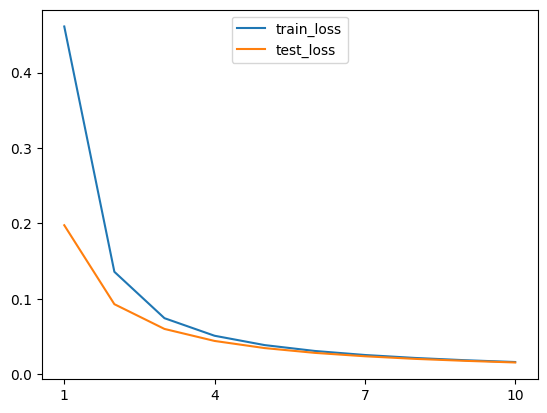

In [74]:
# Define model and parameters
model = NCF(num_users, num_jobs, embedding_dim=5, hidden_dim=32, pretrained_user_embs = None, pretrained_item_embs = None)
lr = 0.001
num_epochs = 10

# Train the model
train_loss, test_loss, user_latent, item_latent = train_NCF(model, train_dataloader, test_dataloader, lr, num_epochs)

In [75]:
print(item_latent)

tensor([[-2.3334e-01,  1.1084e-03, -5.9337e-01, -8.5852e-01,  1.1274e+00],
        [-4.3787e-01, -1.3580e+00,  1.2666e+00,  6.2956e-01, -5.4515e-01],
        [-1.2914e+00,  2.3370e-02, -1.8101e+00, -7.9350e-01,  4.5231e-01],
        [ 1.6650e+00, -7.7324e-01,  2.5449e-01,  2.7486e-01, -1.5091e+00],
        [-1.4104e+00, -7.2046e-02,  8.2333e-01,  1.0963e+00, -4.2022e-01],
        [ 8.2678e-01,  5.9192e-01,  3.3511e-01,  1.6555e+00, -1.1716e+00],
        [-1.0083e+00, -1.2765e-01,  6.8722e-01, -1.3035e+00,  2.0237e+00],
        [-3.9258e-01,  1.7308e+00,  4.1756e-01, -7.5156e-01, -8.7196e-01],
        [ 1.6440e+00, -9.3750e-01, -7.6386e-01,  1.2311e+00, -1.6625e+00],
        [-2.5619e-01,  2.3656e-01,  8.8685e-01,  7.8950e-01,  3.8159e-01],
        [-1.2260e+00,  2.7318e-01, -1.4342e+00, -7.1707e-01,  5.7676e-01],
        [-1.6173e-01,  1.4378e-01, -9.3109e-01,  4.3176e-01, -1.2777e+00],
        [-9.0566e-01, -1.4155e+00,  3.7067e-01, -6.7413e-01,  1.1852e+00],
        [-8.0231e-01, -7.

## NCF + MF with the pretrained embeddings

Epoch 1 of 10: RMSE Train Loss: 0.2922, RMSE Test Loss: 0.0364
Epoch 2 of 10: RMSE Train Loss: 0.0236, RMSE Test Loss: 0.0154
Epoch 3 of 10: RMSE Train Loss: 0.0122, RMSE Test Loss: 0.0098
Epoch 4 of 10: RMSE Train Loss: 0.0082, RMSE Test Loss: 0.0071
Epoch 5 of 10: RMSE Train Loss: 0.0062, RMSE Test Loss: 0.0055
Epoch 6 of 10: RMSE Train Loss: 0.0049, RMSE Test Loss: 0.0045
Epoch 7 of 10: RMSE Train Loss: 0.0040, RMSE Test Loss: 0.0038
Epoch 8 of 10: RMSE Train Loss: 0.0034, RMSE Test Loss: 0.0032
Epoch 9 of 10: RMSE Train Loss: 0.0029, RMSE Test Loss: 0.0028
Epoch 10 of 10: RMSE Train Loss: 0.0026, RMSE Test Loss: 0.0024


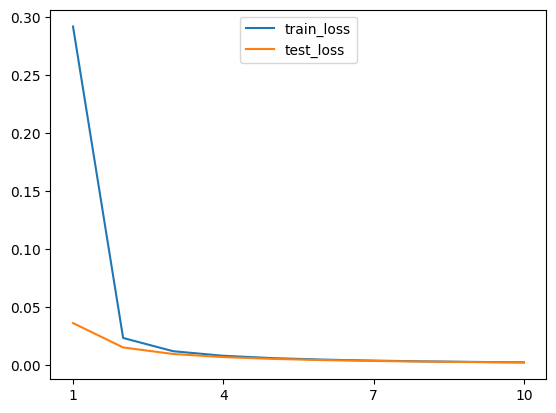

In [76]:
# Define model and parameters
model_with_laten_factors = NCF(num_users, num_jobs, embedding_dim=5, hidden_dim=64, pretrained_user_embs = P1, pretrained_item_embs = Q1.T)
lr = 0.001
num_epochs = 10

# Train the model
train_loss_with_laten_factors, test_loss_with_laten_factors, user_latent_with_laten_factors, item_latent_with_laten_factors = train_NCF(model_with_laten_factors, train_dataloader, test_dataloader, lr, num_epochs)

In [87]:
user_latent_with_laten_factors

tensor([[ 0.5669,  0.2255,  0.2136,  0.5892,  0.8038],
        [ 0.7105,  0.4122,  0.3984,  0.4225,  0.4246],
        [ 0.3676,  0.5374,  0.7373,  0.7232,  0.2294],
        [ 0.4953,  0.6275,  0.5157,  0.2996,  0.6034],
        [ 0.1527,  0.2720,  0.8021,  0.4354,  0.7499],
        [ 0.6907,  0.2323,  0.7683,  0.7793,  0.1423],
        [ 0.3475,  0.5452,  0.2634,  0.6170,  0.6568],
        [ 0.3860,  0.5955,  0.3527,  0.7858,  0.3365],
        [ 0.5109,  0.5343,  0.4553,  0.5028,  0.5744],
        [ 0.6430,  0.4529,  0.4442,  0.3855,  0.5507],
        [ 0.9995,  0.2515,  0.1102,  0.4351,  0.2725],
        [ 0.7143,  0.7124,  0.2278,  0.1704,  0.5153],
        [ 0.1447,  0.4468,  0.6944,  0.3646,  0.6778],
        [ 0.2571,  0.5123,  0.7352,  0.4317,  0.3815],
        [ 0.2805,  0.0836,  0.4976,  0.4761,  0.1291],
        [ 0.2708,  0.8537,  0.5472,  0.8972,  0.3542],
        [ 0.5354,  0.3363,  0.6474,  0.5184,  0.5598],
        [ 0.4629,  0.9250,  0.4098,  0.1654,  0.5284],
        [ 

In [86]:
result = np.dot(user_latent.detach().numpy(), item_latent.detach().numpy().T)

In [80]:
result

array([[ 1.0608435 ,  1.5989398 ,  1.149435  , ..., -1.7199792 ,
         1.8707467 , -1.3191156 ],
       [-0.4190069 , -3.960667  , -0.08724787, ..., -0.66112125,
        -1.680675  ,  0.02787339],
       [-1.8355203 ,  1.6094096 , -0.20891154, ...,  0.9775451 ,
         0.475854  ,  1.3833618 ],
       ...,
       [-1.651911  , -4.16412   ,  0.47091225, ..., -1.4371368 ,
         0.15493798, -0.42769814],
       [-1.073612  ,  1.4921563 ,  0.22956586, ..., -1.2258668 ,
         2.820637  , -1.4656448 ],
       [ 1.4137938 , -0.52322817,  0.04266527, ..., -1.6182353 ,
        -0.22820288, -1.672533  ]], dtype=float32)

In [83]:
result_MF = np.dot(P1, Q1)

In [84]:
result_MF

array([[1.07768877, 1.07215992, 0.96990665, ..., 1.3478393 , 1.09857882,
        1.31020168],
       [0.94588442, 0.94522841, 1.05869077, ..., 1.27506179, 0.92094694,
        1.0436826 ],
       [0.90762048, 0.88574284, 1.01532291, ..., 1.20066597, 0.93661495,
        1.07420544],
       ...,
       [0.95239583, 0.9995246 , 0.94712471, ..., 1.07793765, 1.04220854,
        1.26180798],
       [1.04391231, 1.1536564 , 1.16423113, ..., 1.39242059, 1.01161515,
        1.41490067],
       [1.13390353, 1.10007602, 0.96824018, ..., 1.67218398, 1.01321411,
        1.34016321]])

In [81]:
import pickle
with open("Result", "wb") as f1:
  pickle.dump(result, f1)

In [93]:
similarities = np.dot(user_latent.detach().numpy(), item_latent.detach().numpy().T) / (np.linalg.norm(item_latent.detach().numpy(), axis=1) * np.linalg.norm(user_latent.detach().numpy()))


In [123]:
def recommend_jobs_for_user(user_id):
    job_similarities = similarities[:, user_id]
    top_indices = np.argsort(job_similarities)[::-1][:10]
    recommended_job_ids = [jobs['Title'][i]  for i in top_indices]

    return recommended_job_ids



In [124]:
recommend_jobs_for_user(90)

['Data Entry - full time',
 'Greeter',
 'Claims Examiner',
 'Shipping Coordinator',
 'CUSTOMER SERVICE REPRESENTATIVE',
 'Secretary/Registrar    position available May 1, 2012',
 'Account Manager',
 'Human Resource Associate',
 'Office Assistant',
 'Front Desk/Night Audit']

In [ ]:
def predict(model, user_idx, item_idx):
    model.eval()
    with torch.no_grad():
        user_tensor = torch.LongTensor([user_idx])
        item_tensor = torch.LongTensor([item_idx])
        output, _, _ = model(user_tensor, item_tensor)
        probability = output.item()  # Output already contains probability after sigmoid
    return probability

print(predict(model_with_laten_factors, 90, 695))

**ANALYSIS**

MF or NCF would just not work on the dataset we have. It is very difficult to do collaborative filtering tasks on such dataset with on binary 1s and 0s. <br>

We will be moving to a content based recommendation system, which uses the text of the data to recommend jobs.